In [1]:
# importing the necessary modules
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt
import seaborn as sns

## Product relationships and propensity to purchase

The questions to answer with this data are:
- What product category leads to the highest spend on the return purchases?
- What product category leads to the fastest return to purchase?
- What are the chances that they return to purchase the same item?
- If a customer purchases X product category first, what are they likely to buy next and when?
- If a customer doesn’t repurchase again within ‘X’ amount of time, they are unlikely to purchase again for X (by product category)

#### From meeting on 06/02/23

Points from the call:
- Start by looking at the relationship of best sellers to the rest of the products $\checkmark$
- Focus on Accessories and scooters and ignore the rest, at least for now $\checkmark$
- Find the 5 best sellers out of them and use them as the starting point for probability of subsequent purchases
- Look at relationship of scooter to scooter, accessory to accessory, accessory to scooter and scooter to accessory
- Look into normal distribution and standard deviation 



In [2]:
# Importing the data from the .xlsx as a data frame using the pandas module
df = pd.read_excel("productRelationships.xlsx", sheet_name = 'Data')
# getting rid of the Clinet_ID column
df = df.drop(columns = "Client_Id")
print(len(df))
# renaming the headings to make it easier to reference them in the script
df.rename(columns = {'Repurchase_Period':'period','First_Product_Category':'first','Subsequent_Product_Category':'subs','Subsequent_Items_Ordered':'subsqty','Subsequent_Net_Value_before_Returns':'subsnet'},inplace=True)
df.head()

13097


,period,first,subs,subsqty,subsnet
0,00 - 06 Month,ACC BAG,ACC BOTTLE,3,22.38
1,00 - 06 Month,ACC BAG,ACC NOISE MAKER,1,9.13
2,00 - 06 Month,ACC BASKET,SCOOTER ELECTRIC,1,416.63
3,00 - 06 Month,ACC BELL,SPARES CLAMPS,2,14.92
4,00 - 06 Month,ACC BELL,SPARES WHEELS,13,161.61


#### Finding the best sellers
First, some filtering has to be done.

The dataset will be reduced to only show rows referring to scooters and accessories like we spoke about. Also, removing any that have 'X CHILLI' in as we mentioned as well.

I will also create a subset for just scooters and just accessories.

In [3]:
# Finding all lines that include accessory or scooter in the first purchase column
acc_or_scoot_1 = df['first'].str.contains('|'.join(['ACC ', 'SCOOTER']))

# all locations that dont have xchilli
not_xchilli = ~df['first'].str.contains('X CHILLI') & ~df['subs'].str.contains('X CHILLI')

# those in subsequent purchase column
acc_or_scoot_2 = df['subs'].str.contains('|'.join(['ACC ', 'SCOOTER']))

# d1 includes all accessories and scooters
d1 = df.loc[acc_or_scoot_1 | acc_or_scoot_2 | not_xchilli]
print(len(d1))
# acc_only will only include accessories
acc_only = df.loc[df['first'].str.contains('ACC') & df['subs'].str.contains('ACC')]

# scoot_only will only include scooters
# Finding all locations where first purchase and subsequent purchase is Scooter
scoot = df['first'].str.contains('SCOOTER') & df['subs'].str.contains('SCOOTER')
scoot_only = df.loc[scoot & not_xchilli]

13074


Working out which products out of the accessories and scooters are most popular. Below shows the top 5 best sellers on the first purchase along with the amount of customers that bought each in the dataframe

In [4]:
# barsize will control the size of the bar charts below. (x inches, y inches)
barsize = (12,3)
print("Category\tQTY of Customers")
top = d1['first'].value_counts().head(5)
top

Category	QTY of Customers


SCOOTER MINI      523
SCOOTER MAXI      491
SCOOTER SPRITE    466
SPARES GRIPS      449
ACC HELMET        433
Name: first, dtype: int64

Cell 5 forms a list with these top categories for the next function.

In [5]:
#names now holds the names in the list above
names = top.index.tolist()

From here, I will see what a bar chart looks like for each of these categories mapped onto the rest of the accessories and scooters.

Cell 6 below is a function to display the barchart by just entering the name of the category as seen in cell 7. 

In [6]:
#barchart function, just enter any category from scooter or accessory
def bestsellbar(name, barsize=(12,5)):
    d_product = d1.loc[d1['first'].str.contains(name)]
    d_product['subs'].value_counts(normalize=True).mul(100).plot(kind='bar',figsize=barsize)
    plt.title('Chart to show percetage of customers to subseqently buy each category after purchasing %s\n'%name)
    plt.xlabel('Category')
    plt.locator_params(axis='y',nbins=40)
    plt.ylabel('Percentage of customers [%]')

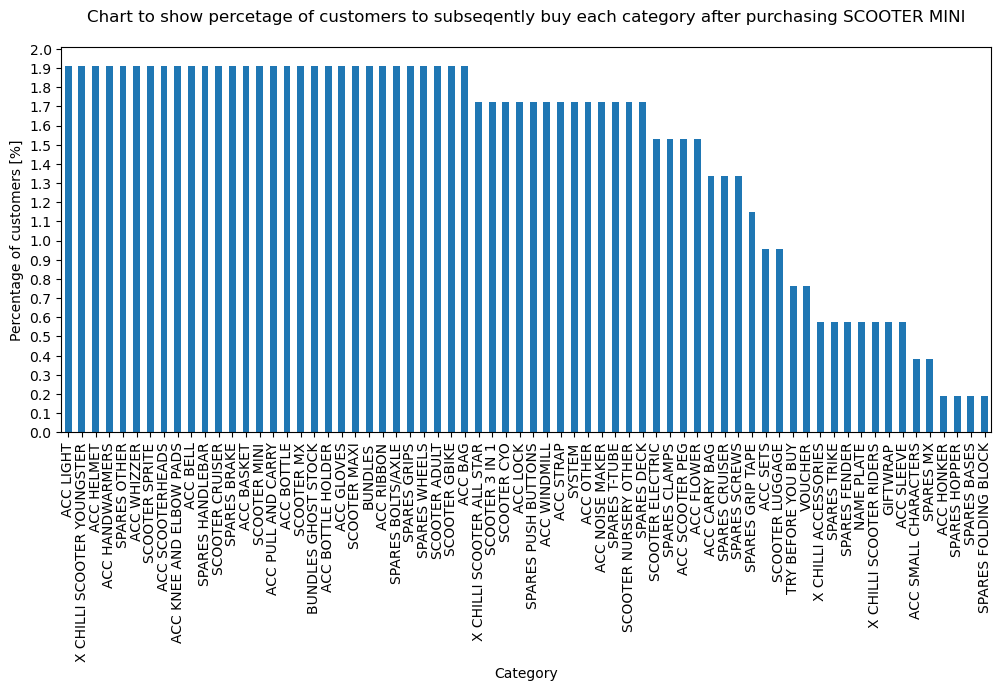

In [7]:
#names[0] is the first item in the list which is SCOOTER MAXI
bestsellbar(names[0])

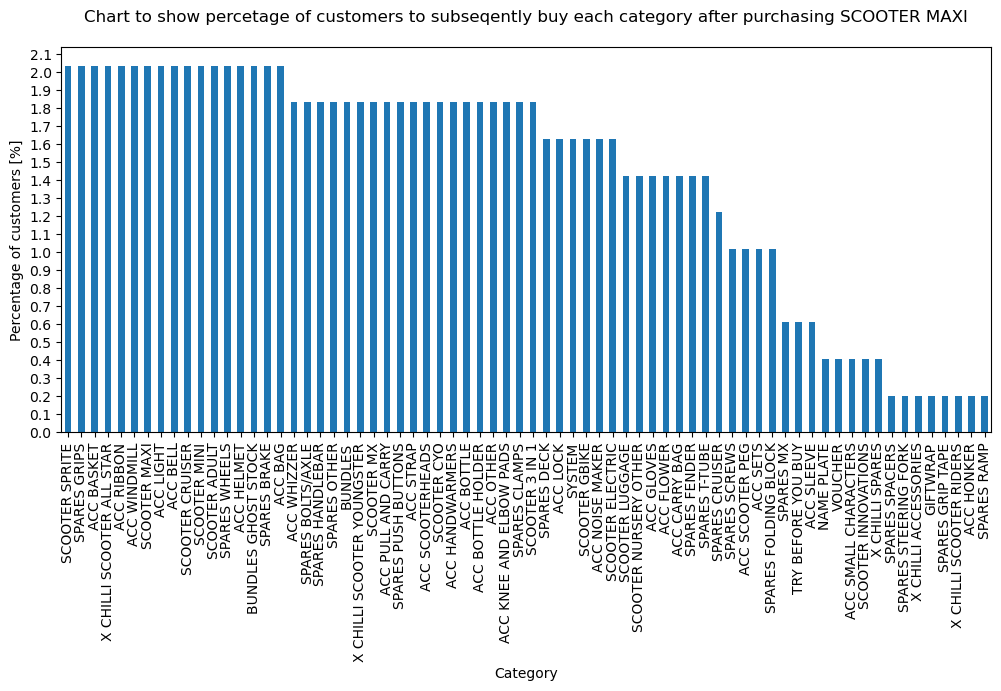

In [8]:
# names[1] contains the category SCOOTER MAXI
bestsellbar(names[1])

I've only plotted the top 2 to minimize clutter. Looking at these charts, you can clearly see the most popular categories to purchase subsequently however, I think its more important to see the relationship of subsequent purchases between each of the top first purchases. Below is a function to print the top purchases susequently but as a list to see the values clearer. I have only shown the example for ACC HELMET. I was surprised by how many categories had the same amount of subsequent buys.

In [9]:
def topsubs(name):
    d_product = d1.loc[d1['first'].str.contains(name)]
    print('Subsequent to %s' % name)
    print(' ')
    print(d_product['subs'].value_counts().head(10))
    print("There are %.0f customers that bought a %s" % (len(d_product),name))
    print('-------------------')

#for name in names:
    #topsubs(name[0])

topsubs(names[0])

Subsequent to SCOOTER MINI
 
ACC LIGHT                     10
X CHILLI SCOOTER YOUNGSTER    10
ACC HELMET                    10
ACC HANDWARMERS               10
SPARES OTHER                  10
ACC WHIZZER                   10
SCOOTER SPRITE                10
ACC SCOOTERHEADS              10
ACC KNEE AND ELBOW PADS       10
ACC BELL                      10
Name: subs, dtype: int64
There are 523 customers that bought a SCOOTER MINI
-------------------


The next function will plot the subseqnent purchases for all top 5 first buys as this should give us more insight into the relationship

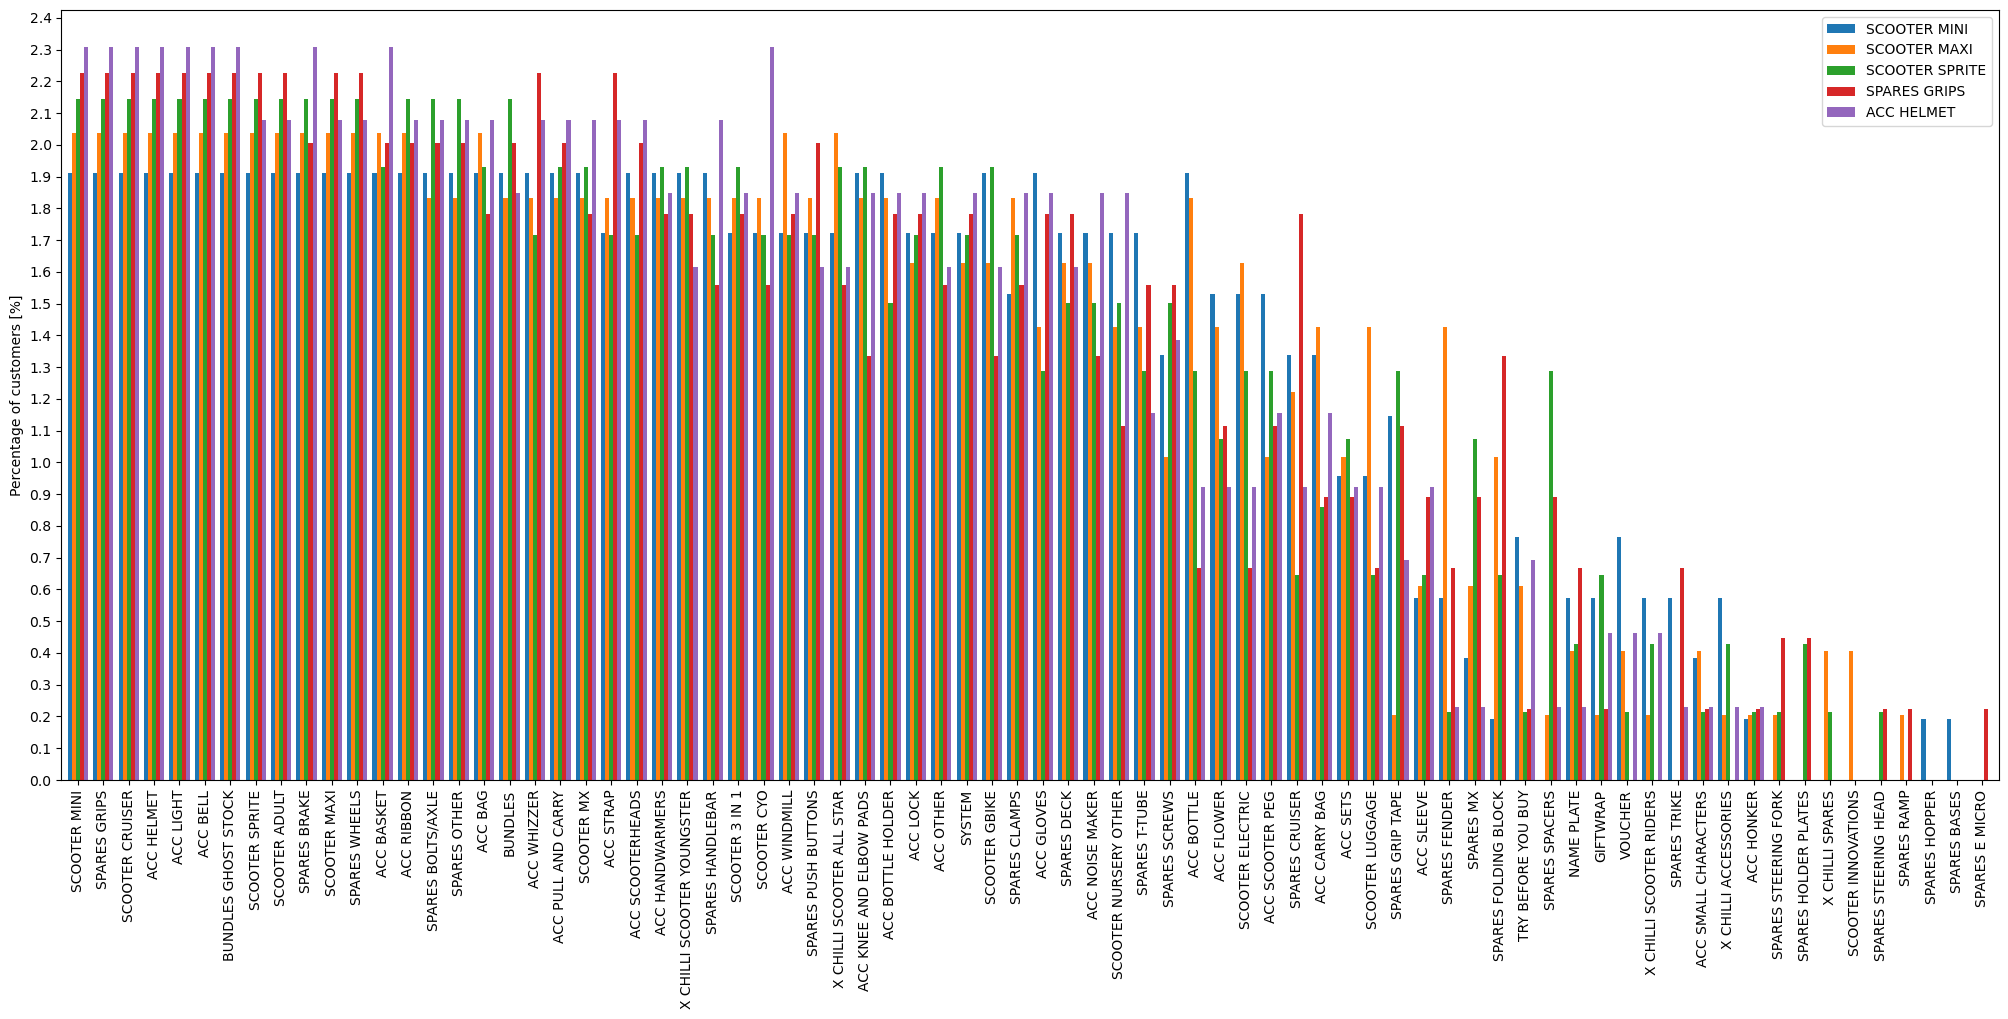

In [10]:
#barchart function, just enter any category from scooter or accessory
def bestsellbarmult(names, barsize=(25,10)):
    d_product = []
    index = d1.loc[d1['first'].str.contains('|'.join(names))]
    index = index['subs'].value_counts().index
    df = pd.DataFrame(index = index)
    
    for i in range(len(names)):
        d_product = d1.loc[d1['first'].str.contains(names[i])]
        d_product = d_product['subs'].value_counts(normalize=True).mul(100)
        df[names[i]] = d_product
    ax = df.plot.bar(rot=90,figsize = barsize, width=0.8)
    plt.locator_params(axis='y',nbins=40)
    ax.set_ylabel("Percentage of customers [%]")

bestsellbarmult(names)

The percentages for each bar are the percentage of customers that bought that category after buying a particular first item. So interestingly enough, the highest probability of returning to buy a helmet, is if you have bought a helmet the first time. This may be interesting to show in periods as well as it could be down to breaking a helmet? I need to make sure that the logic is sound here but I think that this plot can be interpreted in this way. But then, if this is only data for those customers who returned to purchase, there isn't a 3.5% chance that they will buy a helmet if they bought a helmet to begin with. There is a 3.5% chance that they will subsequently buy a helmet after first buying a helmet, as long as they intend to purchase another category.

To calculate the probability of buying a category after another, you would also require the data for customers that did not return to purchase again.

Note: The barchart is naturally in the order of SCOOTER MAXI as that is the first name, I've changed it to be in the order of total sum of subseqent purchases.

<AxesSubplot:ylabel='period'>

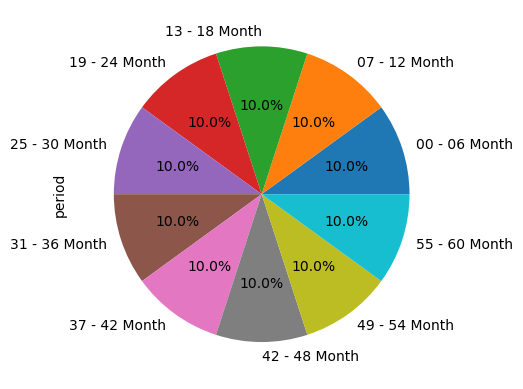

In [11]:
helmets = df['first'].str.contains('ACC HELMET') & df['subs'].str.contains('ACC LIGHT')
helmets = d1.loc[helmets]
helmets['period'].value_counts().plot(kind='pie',autopct='%1.1f%%')

In [12]:
def bestselloverall(names, barsize=(12,3)):
    d_product = d1.loc[d1['first'].str.contains('|'.join(names))]
    #normalize=True divides all of the values by the sum of values
    d_product['subs'].value_counts(normalize=True).mul(100).plot(kind='bar', figsize=barsize)
    plt.ylabel("Percentage of customers [%]")
    plt.xlabel("Category")
    plt.title('Bar chart to show what customers are most likely to purchase subsequently to the %s\n' % names)
    plt.locator_params(axis='y', nbins=30)

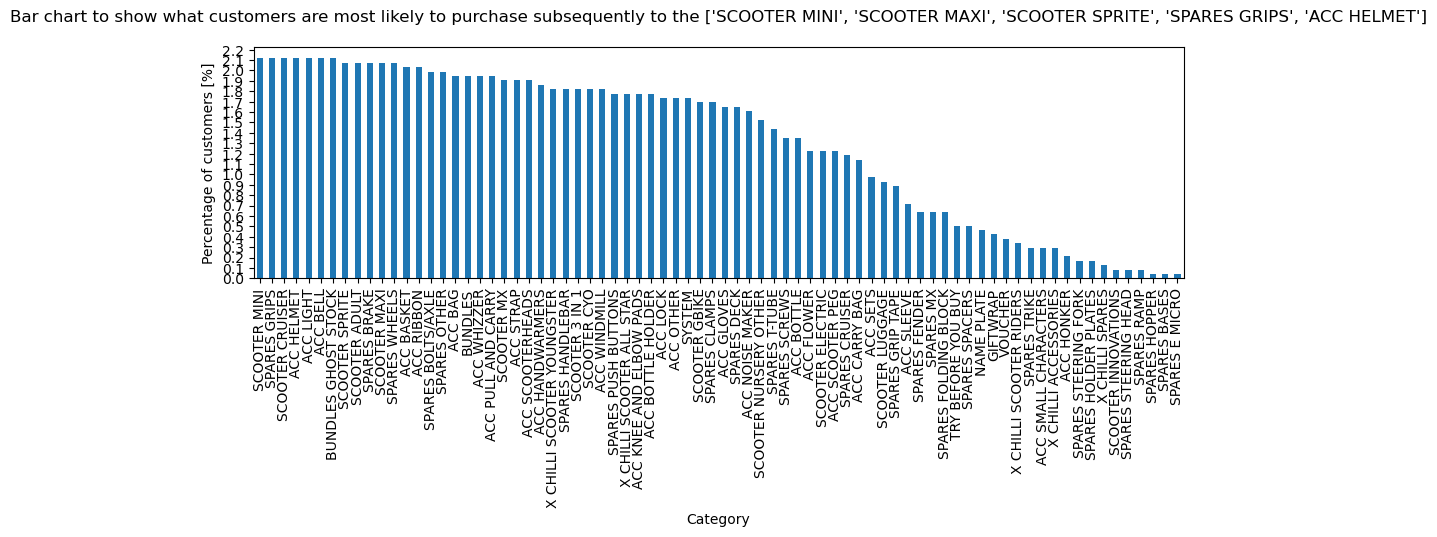

In [13]:
bestselloverall(names)

This chart shows the percentage of returning customers buying each item for all 5 top first categories combined. So if you bought any of the top 5, this is what percentage of those customers bought each subsequent category.

In [14]:
categories = ['SCOOTER MINI','SCOOTER MAXI','SCOOTER 3 IN 1','SCOOTER SPRITE','ACC HELMET']
d_product = d1.loc[d1['first'].str.contains('|'.join(categories))]
print('Subsequent to %s'%categories)
print(' ')
print(d_product['subs'].value_counts().head(10))

Subsequent to ['SCOOTER MINI', 'SCOOTER MAXI', 'SCOOTER 3 IN 1', 'SCOOTER SPRITE', 'ACC HELMET']
 
SCOOTER MINI           50
BUNDLES GHOST STOCK    50
ACC BELL               50
SCOOTER CRUISER        50
SPARES BRAKE           50
SPARES GRIPS           50
ACC LIGHT              50
ACC HELMET             50
SCOOTER ADULT          49
ACC BASKET             49
Name: subs, dtype: int64


### Looking at Accessories alone
Below are the best selling accessories. The function will show the most popular subsequent accessory purchases after buying a certain accessory. The function only requires the input of a category name.

In [15]:
acc_only['first'].value_counts().head(5)

ACC HELMET            186
ACC WHIZZER           152
ACC PULL AND CARRY    141
ACC RIBBON            139
ACC BELL              120
Name: first, dtype: int64

In [16]:
def bestsellbaracc(name, barsize=(12,3)):
    d_product = acc_only.loc[acc_only['first'].str.contains(name)]
    d_product['subs'].value_counts(normalize=True).mul(100).plot(kind='bar', figsize=barsize)
    plt.ylabel("Percentage of customers [%]")
    plt.xlabel("Category")
    plt.title('Bar chart to show what customers are most likely to purchase subsequently to the %s\n' % name)
    plt.locator_params(axis='y', nbins=20)

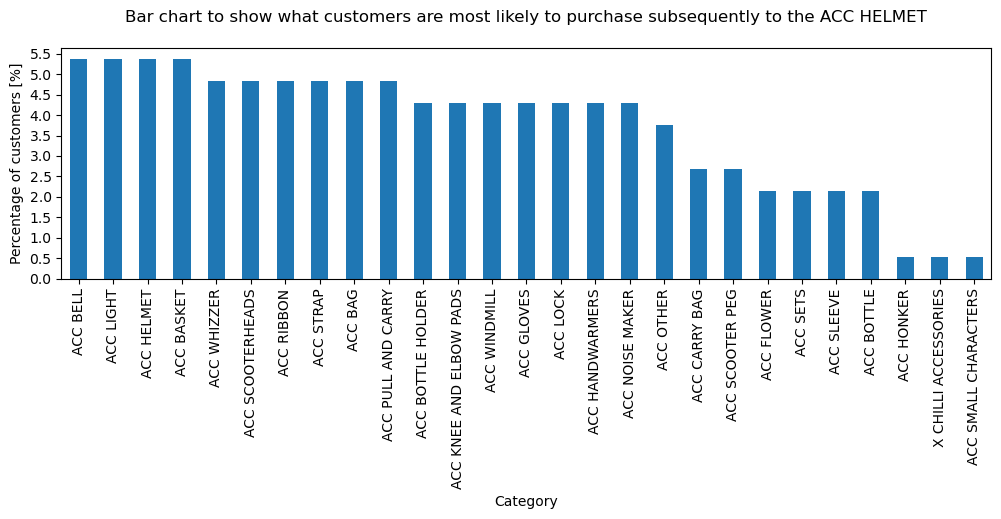

In [17]:
bestsellbaracc('ACC HELMET')

Okay, thats probably enough barcharts for now!

Lets look at Probability

### Standard Deviation and Normal Distribution

The scipy.stats function uses the following equation for the Normal Distribution:
$$f(x)=\frac{exp(-x^2/2)}{\sqrt{2 \pi}}$$

This normal distribution will require the mean value which the curve centres on and the standard deviation with equation:
$$\sigma=\sqrt{\frac{\Sigma(x_i-\mu)^2}{N}}$$

where:

$N$=population size

$x_i$=each value

$\mu$=population mean

By showing the value of the standard deviation before the normal distribution, we can compare the values and see the relationship of dispersion between the categories.

To begin with, the following table shows the most poular susequent purchases, these will then used to caluculate the normal distribution for the quantity ordered and the net value before returns.

In [18]:
barsize = (12,3)
print("Category\tQTY of customers")
top = d1['subs'].value_counts().head(5)
print(top)
#names now holds the names in the list above
names = top.index.tolist()

Category	QTY of customers
ACC HELMET             420
BUNDLES GHOST STOCK    404
ACC BELL               404
SCOOTER MAXI           403
SPARES GRIPS           378
Name: subs, dtype: int64


ACC HELMET has a standard deviation of 1003
BUNDLES GHOST STOCK has a standard deviation of 307
ACC BELL has a standard deviation of 837
SCOOTER MAXI has a standard deviation of 237
SPARES GRIPS has a standard deviation of 209
----------------------------------------
ACC HELMET has a mean of 165
BUNDLES GHOST STOCK has a mean of 62
ACC BELL has a mean of 152
SCOOTER MAXI has a mean of 51
SPARES GRIPS has a mean of 52


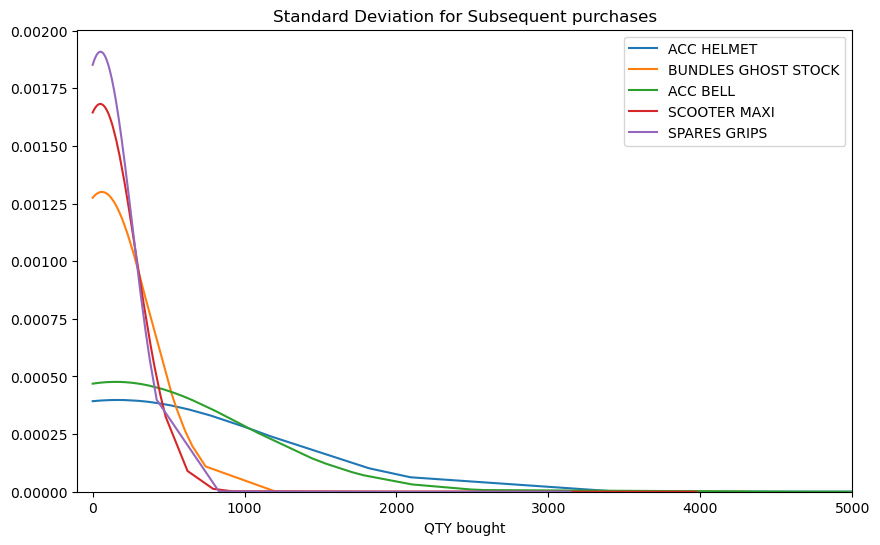

In [19]:
def subsqtydist(names):
    fig, ax = plt.subplots(figsize=(10,6))
    for name in names:
        lines = d1.loc[d1['subs'].str.contains(name)]
        values = lines['subsqty']
        values = values.sort_values(ascending=True)
        vals_mean = np.mean(values)
        vals_stddev = stats.tstd(values)
        nd = norm.pdf(values, vals_mean, vals_stddev)
        print("%s has a standard deviation of %.0f" % (name, vals_stddev))
        ax.plot(values, nd,label=name)
        
    print('----------------------------------------')
    for name in names:
        lines = d1.loc[d1['subs'].str.contains(name)]
        values = lines['subsqty']
        values = values.sort_values(ascending=True)
        vals_mean = np.mean(values)
        print("%s has a mean of %.0f" % (name, vals_mean))

    ax.set_title("Standard Deviation for Subsequent purchases")
    ax.set_xlabel("QTY bought")
    ax.set_xlim([-100,5000])
    ax.set_ylim(0)
    ax.legend()
    #return values

#names[0] will hold ACC HELMET
subsqtydist(names)

Looking at the plot above, the normal distribution of qty for the top 5 most popular categories to subsequently buy have been plotted. I don't think its very surprising that the scooters have the smallest standard deviation as logically, most customers will only want to buy 1. The Helmet has the largest standard deviation meaning there is a wider range of quantities that a customer is likely to buy.

The plot does not look like the classic bell curve that a normal distribution should have, this is just down to the fact that there is a lower limit of purchase qty amounts. You can't buy less than 1.

Next, the same will be plotted but for net value before returns.

ACC HELMET has a standard deviation of 27339
BUNDLES GHOST STOCK has a standard deviation of 9305
ACC BELL has a standard deviation of 4747
SCOOTER MAXI has a standard deviation of 24075
SPARES GRIPS has a standard deviation of 1113
------------------------------------------
ACC HELMET has a mean of 4521
BUNDLES GHOST STOCK has a mean of 2839
ACC BELL has a mean of 867
SCOOTER MAXI has a mean of 5305
SPARES GRIPS has a mean of 276


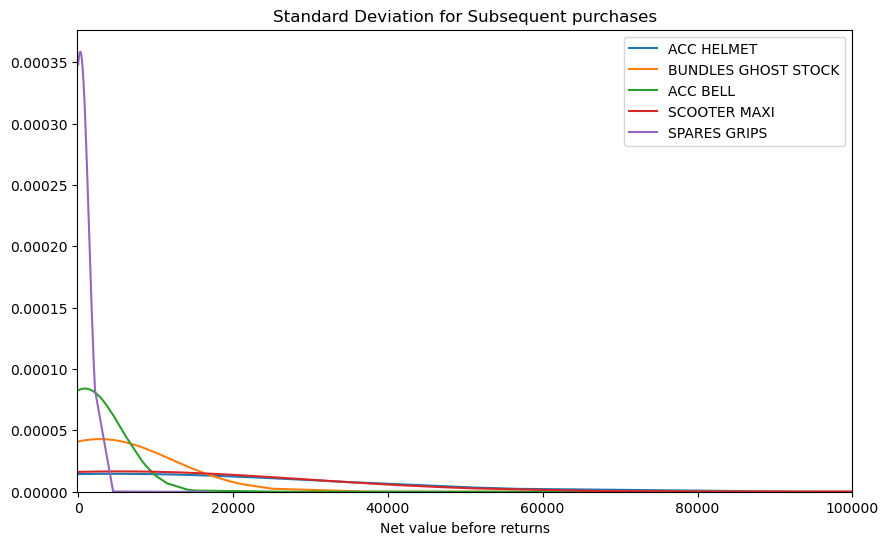

In [20]:
def subsvaldist(names):
    fig, ax = plt.subplots(figsize=(10,6))
    for name in names:
        lines = d1.loc[d1['subs'].str.contains(name)]
        values = lines['subsnet']
        values = values.sort_values(ascending=True)
        vals_mean = np.mean(values)
        vals_stddev = stats.tstd(values)
        nd = norm.pdf(values, vals_mean, vals_stddev)
        print("%s has a standard deviation of %.0f" % (name, vals_stddev))
        ax.plot(values, nd,label=name)
    print('------------------------------------------')
        
    for name in names:
        lines = d1.loc[d1['subs'].str.contains(name)]
        values = lines['subsnet']
        values = values.sort_values(ascending=True)
        vals_mean = np.mean(values)
        print("%s has a mean of %.0f" % (name, vals_mean))
    
    ax.set_title("Standard Deviation for Subsequent purchases")
    ax.set_xlabel("Net value before returns")
    ax.set_xlim([-100,100000])
    ax.set_ylim(0)
    ax.legend()

#names[0] will hold ACC HELMET
subsvaldist(names)

For net value, the light accessory seems to have the smallest standard deviation and also the smallest mean value.
Scooter Maxi has the highest mean net value before returns but one of the highest standard deviations meaning that there is much more of a spread of 

Now maybe it will be more useful to carry out normal distribution analysis between top scooter categories and top accessory categories seperately.

In [21]:
print("Category\tQTY of customers")
top_scoot = scoot_only['subs'].value_counts().head(5)
print(top_scoot)
#names now holds the names in the list above
names_scoot = top_scoot.index.tolist()

Category	QTY of customers
SCOOTER MAXI       112
SCOOTER ADULT      108
SCOOTER CRUISER    107
SCOOTER SPRITE     104
SCOOTER MINI       103
Name: subs, dtype: int64


SCOOTER MAXI has a standard deviation of 237
SCOOTER ADULT has a standard deviation of 106
SCOOTER CRUISER has a standard deviation of 51
SCOOTER SPRITE has a standard deviation of 67
SCOOTER MINI has a standard deviation of 134
----------------------------------------
SCOOTER MAXI has a mean of 51
SCOOTER ADULT has a mean of 27
SCOOTER CRUISER has a mean of 18
SCOOTER SPRITE has a mean of 24
SCOOTER MINI has a mean of 35


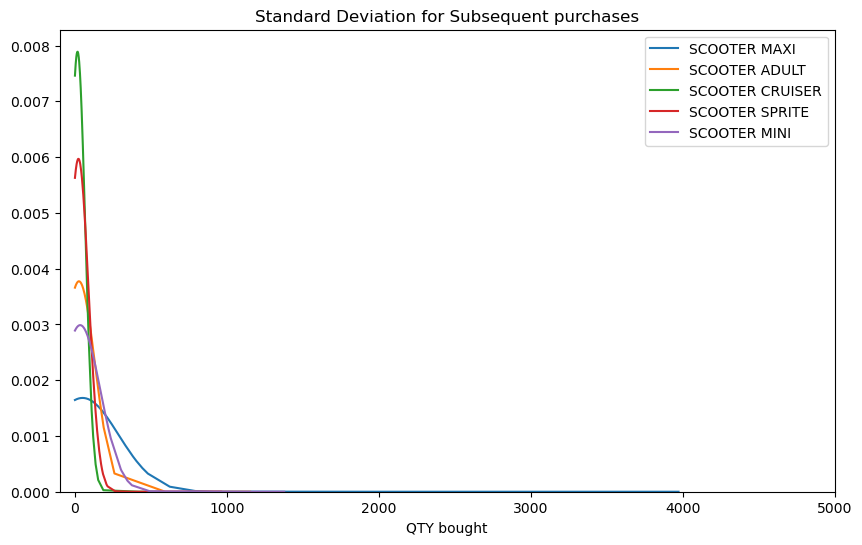

In [22]:
subsqtydist(names_scoot)

In [23]:
print("Category\tQTY of customers")
top_acc = acc_only['subs'].value_counts().head(5)
print(top_acc)
#names now holds the names in the list above
names_acc = top_acc.index.tolist()

Category	QTY of customers
ACC HELMET    166
ACC BELL      161
ACC LIGHT     146
ACC BASKET    126
ACC RIBBON    123
Name: subs, dtype: int64


ACC HELMET has a standard deviation of 1003
ACC BELL has a standard deviation of 837
ACC LIGHT has a standard deviation of 388
ACC BASKET has a standard deviation of 237
ACC RIBBON has a standard deviation of 401
----------------------------------------
ACC HELMET has a mean of 165
ACC BELL has a mean of 152
ACC LIGHT has a mean of 78
ACC BASKET has a mean of 49
ACC RIBBON has a mean of 72


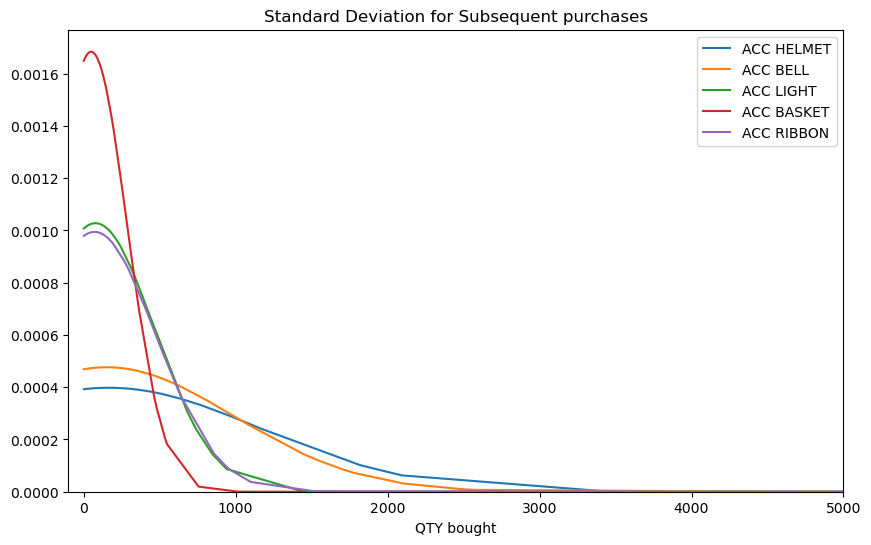

In [24]:
subsqtydist(names_acc)

As seen, by separating the accessories from the scooters, the normal distributions match each other better.
The scooters have a smaller standard deviation and a smaller mean between them meaning that people buy less quantity of the scooters and the qunatity they buy is more easily predicted.

### Looking into the period between purchases

It may be useful to look at 

Text(0, 0.5, '')

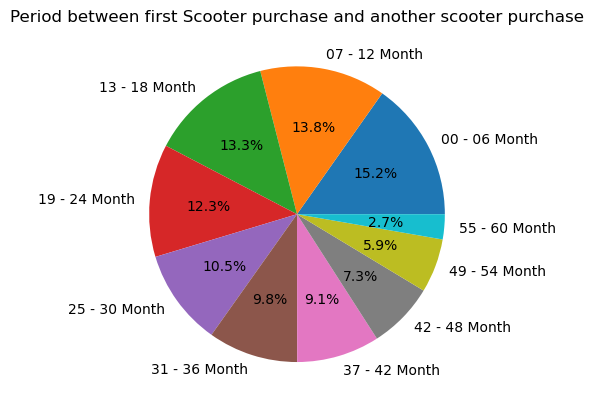

In [25]:
scoot_only['period'].value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.title("Period between first Scooter purchase and another scooter purchase")
plt.ylabel("")
#sort_legend = True
#plt.legend(bbox_to_anchor=(-0.1, 1.))

Text(0, 0.5, '')

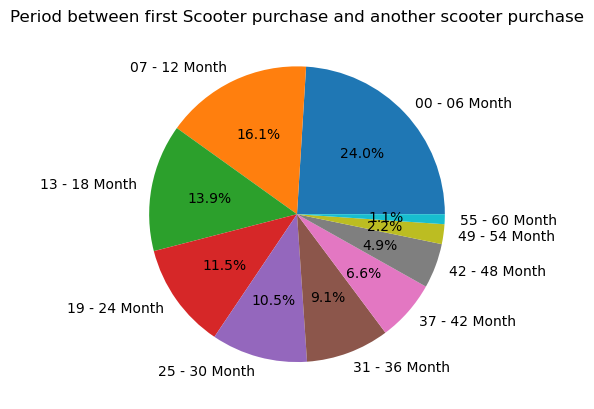

In [26]:
acc_only['period'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Period between first Scooter purchase and another scooter purchase")
plt.ylabel("")

### Looking into probability
Conditional probability is the probability of picking an item given that a certain item has been picked which is what is wanted here.

$$P(B|A) = \frac{P(A \cap B)}{P(A)}$$

In this case, the events are independant (The second event is not influenced by the first event)

$$P(A \cap B) = P(A)xP(B)$$


So, to start with the top seller and the most subseqently bought item. Lets start with:
What is the probability of buying an accessory light after first purchasing a Scooter MINI

In [27]:
print("%.1f%% of customers bought an accessory" % (len(acc_only)/len(d1)*100))
print("%.1f%% of customers bought an scooter" % (len(scoot_only)/len(d1)*100))

14.8% of customers bought an accessory
8.9% of customers bought an scooter


Above, I have literally just divided the number of customers that bought an accessory by the total amount of customers that bought a scooter or an accessory. This is not probability.

In [28]:
scoot_only['first'].value_counts(normalize=True).sort_values(ascending=True)

SCOOTER INNOVATIONS      0.002566
ACC SCOOTER PEG          0.012831
SCOOTER ELECTRIC         0.027374
SCOOTER LUGGAGE          0.041061
ACC SCOOTERHEADS         0.043627
SCOOTER NURSERY OTHER    0.058169
SCOOTER CRUISER          0.067579
SCOOTER GBIKE            0.073567
SCOOTER MX               0.076133
SCOOTER ADULT            0.088109
SCOOTER CYO              0.094953
SCOOTER SPRITE           0.098375
SCOOTER 3 IN 1           0.100941
SCOOTER MAXI             0.105218
SCOOTER MINI             0.109495
Name: first, dtype: float64

In [29]:
d1['first'].value_counts(normalize=True).mul(100).sort_values().head()

SPARES E MICRO          0.030595
SPARES RAMP             0.030595
X CHILLI ACCESSORIES    0.030595
SPARES HOPPER           0.030595
SCOOTER INNOVATIONS     0.030595
Name: first, dtype: float64

In [30]:
d1['subs'].value_counts(normalize=True).mul(100).sort_values(ascending=True).head()

SPARES HOPPER           0.015298
SPARES BASES            0.030595
SCOOTER INNOVATIONS     0.045893
X CHILLI SPARES         0.061190
SPARES STEERING HEAD    0.068839
Name: subs, dtype: float64